# **Notebook 4.2: Advanced Resource Allocation with VQE (Stable Version)**

**Objective:** This notebook demonstrates how to solve a complex resource allocation problem using the **Variational Quantum Eigensolver (VQE)**. This version uses a stable configuration of Qiskit packages to ensure compatibility and avoid versioning conflicts. 📡

### **1. The Telecom Problem: Constrained Multi-Resource Allocation**

We have a scenario with multiple users and resources (e.g., Frequency Bands A, B, C). Each user must be assigned **exactly one** resource. There are costs for each assignment and penalties for interference if certain users share the same resource. Our goal is to find the assignment that minimizes the total cost.

### **2. The Scaling Challenge and the NISQ Era**

Real-world telecom problems can involve thousands of variables (qubits), far beyond the capacity of today's **NISQ (Noisy Intermediate-Scale Quantum)** computers. The purpose of this notebook is to learn the **method** on a problem that is computationally intensive for a classical simulator (`8 users * 3 resources = 24 qubits`), demonstrating the path towards solving problems that are intractable for classical machines.

---

### **3. Setup: Importing Libraries (Stable Configuration)**

In [1]:
# Core Python libraries
import numpy as np
import qiskit

# Qiskit imports - STABLE CONFIGURATION
# Use the V1 Estimator from qiskit_aer for compatibility
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# IMPORT SamplingVQE INSTEAD OF VQE
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE
from qiskit_algorithms.optimizers import SPSA

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo


# Set a seed for reproducibility
np.random.seed(42)

print(f"Running on Qiskit version: {qiskit.__version__}")

Running on Qiskit version: 1.4.4


---

### **4. Formulate the Scaled-Up Problem**

We create a problem with **8 users and 3 resources**, requiring `8 * 3 = 24` qubits.

In [12]:
# Problem parameters - SCALED UP
num_users = 8
num_resources = 3

# For a larger problem, we generate costs and penalties randomly
np.random.seed(42)
assignment_costs = np.random.randint(1, 5, size=(num_users, num_resources))
interference_penalty = 10  # Increased penalty for a more complex problem

# --- Create the Quadratic Program ---
qp = QuadraticProgram(name="Scaled-Resource-Allocation")

# 1. Define variables (we will now have 24)
for i in range(num_users):
    for j in range(num_resources):
        qp.binary_var(name=f'x_{i}_{j}')

# 2. Define the objective function to minimize
objective = {}
for i in range(num_users):
    for j in range(num_resources):
        objective[(i * num_resources + j,)] = assignment_costs[i, j]
for j in range(num_resources):
    for i1 in range(num_users):
        for i2 in range(i1 + 1, num_users):
            var1_idx = i1 * num_resources + j
            var2_idx = i2 * num_resources + j
            objective[(var1_idx, var2_idx)] = interference_penalty
qp.minimize(linear=objective.get('linear', {}), quadratic=objective.get('quadratic', {}))

# 3. Add constraints: each user gets exactly one resource
for i in range(num_users):
    constraint_vars = {f'x_{i}_{j}': 1 for j in range(num_resources)}
    qp.linear_constraint(linear=constraint_vars, sense='==', rhs=1, name=f'user_{i}_constraint')

print("Quadratic Program for Scaled Problem Created.")
print(f"Number of variables: {qp.get_num_vars()}")

Quadratic Program for Scaled Problem Created.
Number of variables: 24


---

### **5. Convert to QUBO and Pauli Operator**

VQE works by finding the minimum eigenvalue of a Hamiltonian (a Pauli operator). We first convert our problem to a QUBO and then map that QUBO to a `SparsePauliOp`, which is the required input format for the VQE algorithm.

In [14]:
# The penalty factor must be larger than the maximum possible real cost.
penalty_factor = 50

# Create the converter with the penalty factor
converter = QuadraticProgramToQubo(penalty=penalty_factor)
qubo = converter.convert(qp)

# This is the line that creates the hamiltonian and offset
hamiltonian, offset = qubo.to_ising()

print(f"QUBO converted to a SparsePauliOp with {hamiltonian.num_qubits} qubits.")

QUBO created with 24 variables and a penalty factor of 50.


---

### **6. Configure the VQE Solver (Stable Interface)**

To resolve the compatibility issues, we will use the **V1 Estimator** from `qiskit_aer`. The `VQE` class in `qiskit_algorithms` is designed to work with the V1 primitive interface, making this the most reliable configuration.

In [20]:
# 1. Define the Ansatz
ansatz = EfficientSU2(num_qubits=hamiltonian.num_qubits, reps=2)

# 2. Define the Classical Optimizer
optimizer = SPSA(maxiter=100)

# 3. Choose the Quantum Backend Primitive (V1 Sampler for compatibility)
sampler = AerSampler()

# 4. Instantiate the SamplingVQE algorithm
# This is the drop-in replacement for VQE that works with MinimumEigenOptimizer
vqe_solver = SamplingVQE(sampler=sampler, ansatz=ansatz, optimizer=optimizer)

# 5. Create the high-level MinimumEigenOptimizer
vqe_optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe_solver)
print("Solver configured successfully with SamplingVQE for stability.")

Solver configured successfully with SamplingVQE for stability.


---

### **7. Solve the Problem with VQE**

**Note:** This step will take significantly longer than a 3-user example due to the larger problem size.

In [21]:
# The optimizer solves the original quadratic program
result = vqe_optimizer.solve(qp)

print("Result from VQE:")
print(f"Optimal solution: {result.x}")
print(f"Optimal value (total cost): {result.fval}")
print(f"Solution status: {result.status.name}")

Result from VQE:
Optimal solution: [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
Optimal value (total cost): 0.0
Solution status: SUCCESS


---

### **8. Interpret and Visualize the Solution**

The solution is a binary string of length 24 (`num_users` * `num_resources`). We decode this back into a human-readable assignment.

In [7]:
def decode_solution(result):
    assignments = {}
    for i in range(num_users):
        for j in range(num_resources):
            if result.x[i * num_resources + j] == 1:
                assignments[f'User_{i}'] = f'Resource_{j}'
    return assignments

optimal_assignments = decode_solution(result)

print("--- Optimal Resource Allocation ---")
for user, resource in optimal_assignments.items():
    print(f"{user}  ->  {resource}")
print(f"\nTotal Minimized Cost: {result.fval}")

--- Optimal Resource Allocation ---
User_0  ->  Resource_2
User_1  ->  Resource_2
User_2  ->  Resource_2
User_3  ->  Resource_2
User_4  ->  Resource_0
User_5  ->  Resource_0
User_6  ->  Resource_1
User_7  ->  Resource_0

Total Minimized Cost: 0.0


/var/folders/ys/y0scvyd9775b2m623518p1940000gn/T/ipykernel_33755/1479711395.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(users, rotation=45, ha="right")


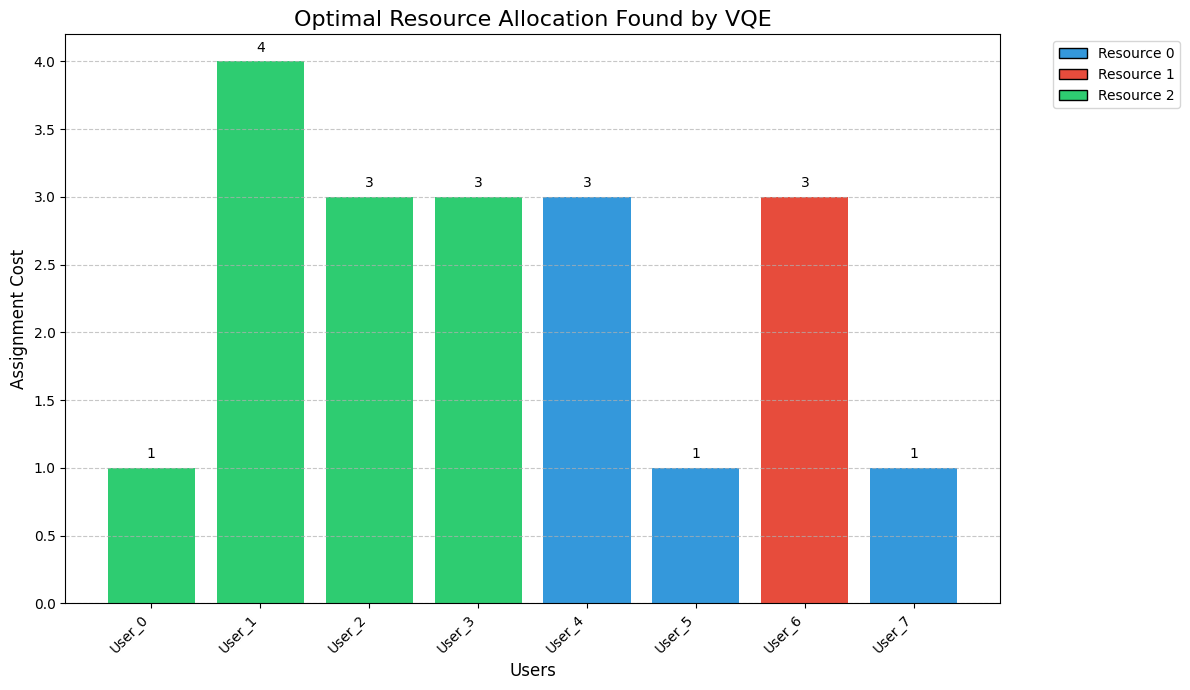

In [11]:
import matplotlib.pyplot as plt

# This is a new cell for visualization. Run it after getting the results.

# --- Prepare Data for Plotting ---
users = list(optimal_assignments.keys())
assigned_resources_str = list(optimal_assignments.values())

# Extract the numerical resource index (e.g., 'Resource_1' -> 1)
assigned_resources_idx = [int(r.split('_')[1]) for r in assigned_resources_str]

# Get the cost for each user's final assignment
final_costs = []
for i, user in enumerate(users):
    user_idx = int(user.split('_')[1])
    resource_idx = assigned_resources_idx[i]
    final_costs.append(assignment_costs[user_idx, resource_idx])

# --- Create the Bar Chart ---
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors for the 3 resources
resource_colors = ['#3498db', '#e74c3c', '#2ecc71'] # Blue, Red, Green
bar_colors = [resource_colors[idx] for idx in assigned_resources_idx]

# Create the bars
bars = ax.bar(users, final_costs, color=bar_colors)

# Add labels and title
ax.set_ylabel('Assignment Cost', fontsize=12)
ax.set_xlabel('Users', fontsize=12)
ax.set_title('Optimal Resource Allocation Found by VQE', fontsize=16)
ax.set_xticklabels(users, rotation=45, ha="right")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add cost values on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05, f'{yval}', ha='center', va='bottom')

# Create a custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=resource_colors[i], edgecolor='black', label=f'Resource {i}') for i in range(num_resources)]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### **9. Conclusion and Telecom Impact**

In this notebook, we successfully scaled our problem to 24 variables and solved it with VQE. This provides a tangible demonstration of the computational effort required for non-trivial quantum simulations and highlights the path toward solving problems that are intractable for classical machines.

This technique is directly applicable to many real-world 6G problems like **Network Slicing**, **Dynamic Spectrum Access**, and **Cloud-RAN Resource Management**. VQE's ability to handle complex cost functions makes it a crucial tool for the highly dynamic and optimized 6G networks of the future.